In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

import joblib

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

%matplotlib inline

## Import Data

In [16]:
train_path, test_path = '../data/processed/train_Bearing_Nasa.csv', '../data/processed/test_Bearing_Nasa.csv'
train, test = pd.read_csv(train_path), pd.read_csv(test_path) 

train = train.set_index('Date_parsed')
test = test.set_index('Date_parsed')

### Scaling

In [17]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
scaler_filename = "../models/scaler_data"
joblib.dump(scaler, scaler_filename)

['../models/scaler_data']

## Modeling

### RandomizedSearch Autoencoder

In [18]:
# Build the autoencoder model
def create_autoencoder(input_dim, num_hidden_layers, hidden_layer_sizes, learning_rate):
    inputs = Input(shape=(input_dim,))
    encoded = inputs
    
    for layer_size in range(num_hidden_layers):
        encoded = Dense((hidden_layer_sizes/(layer_size+1)), activation='relu')(encoded)
        encoded = Dropout(rate=0.2)(encoded)
    decoded = encoded

    for layer_size in range(num_hidden_layers):
        decoded = Dense((hidden_layer_sizes/(layer_size+1)), activation='relu')(decoded)
        encoded = Dropout(rate=0.2)(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs, decoded)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    return autoencoder

# Define the search space and search for the best hyperparameters using RandomizedSearchCV
params = {
    'input_dim': [4,4],
    'num_hidden_layers': range(1, 5),
    'hidden_layer_sizes': [8, 16, 32, 64],
    'learning_rate': [10 ** i for i in range(-4, -1)]
}

autoencoder_model = KerasRegressor(build_fn=create_autoencoder)

# create the randomized search object
autoencoder_search = RandomizedSearchCV(estimator=autoencoder_model,
                                        param_distributions=params,
                                        cv=5,
                                        n_jobs=3)

early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")

# fit the randomized search object to the training data
autoencoder_search.fit(train_scaled,train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.7,
                    shuffle=True,
                    callbacks=[early_stopping])

print(autoencoder_search.best_score_)
print(autoencoder_search.best_params_)

Epoch 1/100
Epoch 1/100
Epoch 1/100
17/17 [==============================] - 1s 20ms/step - loss: 0.0460 - val_loss: 0.2758
Epoch 2/100
17/17 [==============================] - 1s 19ms/step - loss: 0.0531 - val_loss: 0.2061
Epoch 2/100
17/17 [==============================] - 1s 20ms/step - loss: 0.0533 - val_loss: 0.2176
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.2322
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.1963
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.2130
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.2177
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.2116
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.2159
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0091 - 

#### Training Result

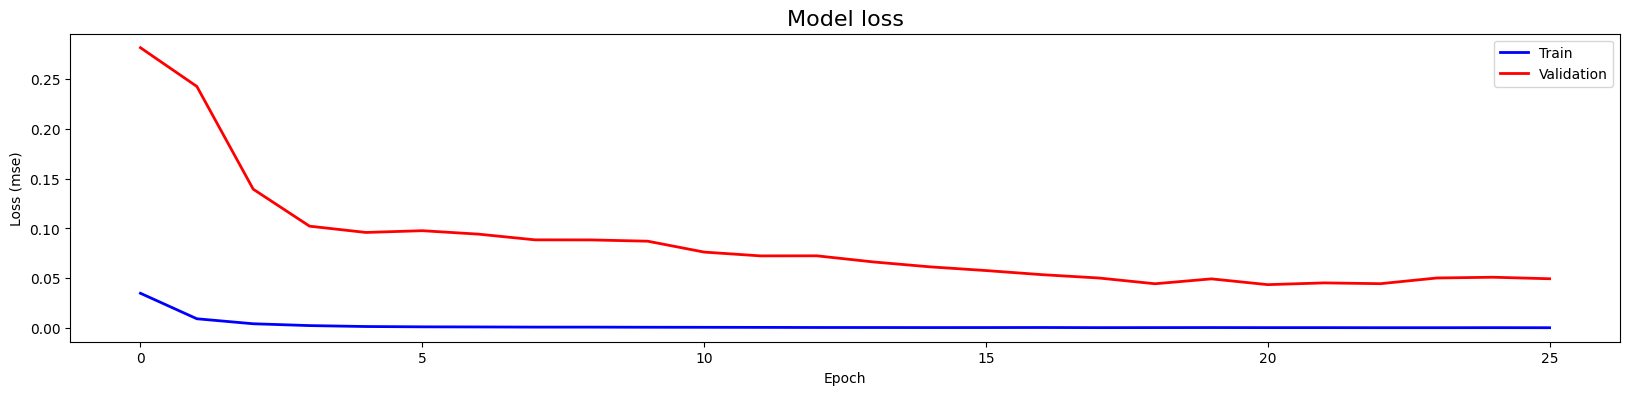

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(autoencoder_search.best_estimator_.model.history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(autoencoder_search.best_estimator_.model.history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [20]:
reconstructions = autoencoder_search.predict(train_scaled)
train_mae_loss = np.mean(np.abs(reconstructions - train_scaled), axis=1)

#threshold = np.max(train_mae_loss)
threshold = np.mean(train_mae_loss) + 2*np.std(train_mae_loss)
print("Global Reconstruction error threshold: ", threshold)

23/23 [==============================] - 0s 2ms/step
Global Reconstruction error threshold:  0.14006156106221765


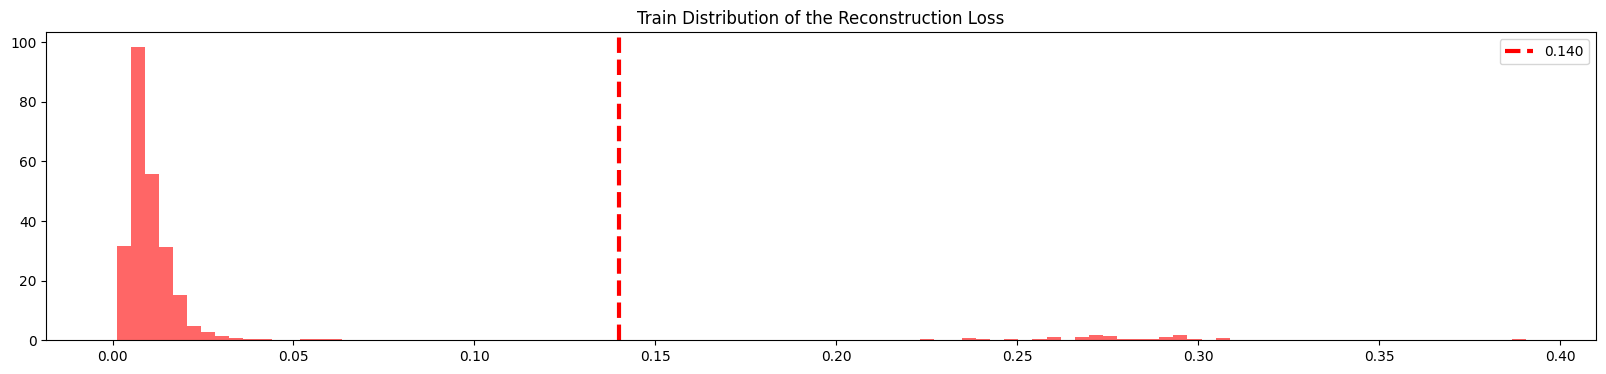

In [21]:
fig, ax = plt.subplots(figsize=(20,4))

ax.hist(train_mae_loss, bins=100, density=True, alpha=.6, color="red")
plt.axvline(threshold, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Train Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

#### Testing Result

In [22]:
reconstructions = autoencoder_search.predict(test_scaled)
test_mae_loss = np.mean(np.abs(reconstructions - test_scaled), axis=1)

8/8 [==============================] - 0s 2ms/step


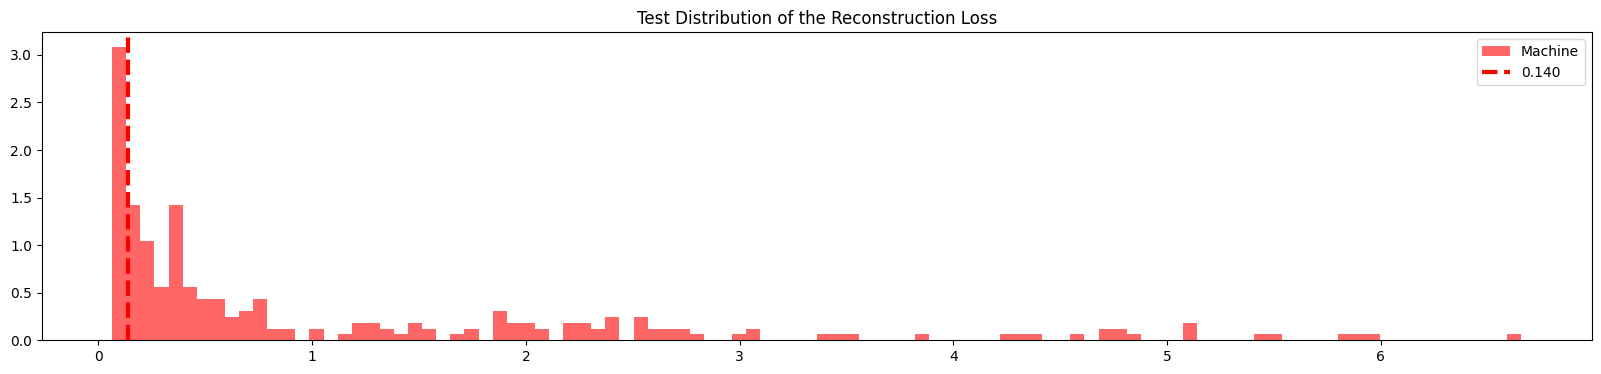

In [23]:
fig, ax = plt.subplots(figsize=(20,4))

ax.hist(test_mae_loss, bins=100, density=True, label="Machine", alpha=.6, color="red")
plt.axvline(threshold, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Test Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

### Anomalies Visualization

In [24]:
test['Loss'] = test_mae_loss
test.loc[test['Loss'] <= threshold, 'Anomaly'] = "Normal"
test.loc[test['Loss'] >= threshold, 'Anomaly'] = "Anomaly"
test.head(3)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Loss,Anomaly
Date_parsed,,,,,,
2004-02-17 13:32:39,0.103776,0.076850,0.078618,0.050461,0.192463,Anomaly
2004-02-17 13:42:39,0.101590,0.075820,0.077957,0.050430,0.166056,Anomaly
2004-02-17 13:52:39,0.106605,0.077271,0.079289,0.051178,0.225561,Anomaly


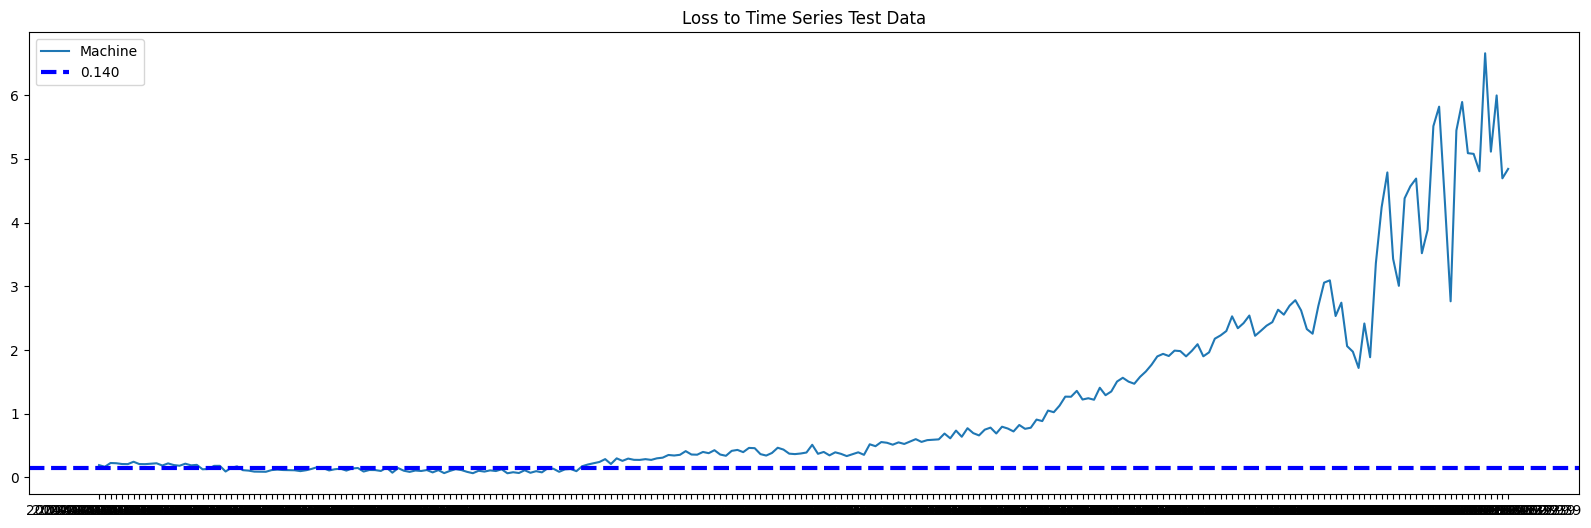

In [25]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test['Loss'], label='Machine')
plt.axhline(threshold, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Loss to Time Series Test Data")
plt.legend()
plt.show()